[![image.png](https://i.postimg.cc/Df6QS0kf/image.png)](https://postimg.cc/s1BG8Vgb)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Оценка риска ДТП</p>
</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ каршеринговая компания.
    
__Постановка задачи:__ разработать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.
    
__Описание задачи:__ Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту. 

__Оценка результата:__ 
    
__Описание данных:__ Исторические данные о ДТП одного из регионов представленные в воде базы данных.
    



</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine

# константы
RANDOM_SEED = 42

## Подключение к базе данных

In [124]:
# конфигурация для подключения к базе данных
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

# создание подключения к базе данных
connection = psycopg2.connect(
    user=db_config['user'],
    password=db_config['pwd'],
    host=db_config['host'],
    port=db_config['port'],
    database=db_config['db']
)

# создаем курсора для выполнения запросов
cursor = connection.cursor()

#### функция для выполнения запросов

In [125]:
# функция для выполнения запросов
def request(query):
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        result_df = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])
        return result_df
    except Exception as e:
        print(f'Error: {e}')
        connection.rollback()  # Откатываем транзакцию, чтобы избежать блокировки

In [23]:
# тестовый запрос
query = '''
SELECT case_id, county_city_location, county_location, distance, direction
FROM collisions
LIMIT 1;
'''
display(request(query))

,case_id,county_city_location,county_location,distance,direction
0,4083072,1942,los angeles,528.0,north


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Подключение к базе данных успешно установлено.
- Функция для выполнения запросов работает корректно.
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Первичное исследование таблиц базы данных

</div>

- Проверим все ли таблицы имеют набор данных;
- Посмотрим количество таблиц;
- Имеется ли общий ключ для связи таблиц.

In [24]:
# создание engine для подключения к базе данных
engine = sqlalchemy.create_engine(
    f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
)
# получение метаданных таблицы
metadata = sqlalchemy.MetaData()
metadata.reflect(bind=engine)

__Общая информация о таблицах__

In [25]:
for table_name, table in metadata.tables.items():
    query = f'SELECT COUNT(*) FROM {table_name};'
    print(f'''
Таблица: {table_name};
Количество записей: {request(query).iloc[0][0]};
Признаки: {table.columns.keys()};
Первичный ключ: {table.primary_key.columns.keys() if table.primary_key else 'Отсутствует'}     
           ''')


Таблица: case_ids;
Количество записей: 1400000;
Признаки: ['case_id', 'db_year'];
Первичный ключ: Отсутствует     
           

Таблица: collisions;
Количество записей: 1400000;
Признаки: ['case_id', 'county_city_location', 'county_location', 'distance', 'direction', 'intersection', 'weather_1', 'location_type', 'collision_damage', 'party_count', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'collision_date', 'collision_time'];
Первичный ключ: Отсутствует     
           

Таблица: parties;
Количество записей: 2752408;
Признаки: ['id', 'case_id', 'party_number', 'party_type', 'at_fault', 'insurance_premium', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use'];
Первичный ключ: Отсутствует     
           

Таблица: vehicles;
Количество записей: 1021234;
Признаки: ['id', 'case_id', 'party_number', 'vehicle_type', 'vehicle_transmission', 'vehicle_age'];
П

<div style="padding: 30px 25px; border: 2px #6495ed solid">

- В базе данных есть три основные таблицы, c наборами данных, но без явно указанных первичных ключей.

- Таблица __'collisions'__ — общая информация о ДТП:
    - Из описания данных известно, имеет уникальный `case_id`, который является уникальным идентификатором для каждого зарегистрированного происшествия;
    - Эта таблица содержит общую информацию о происшествии, включая место, дату и время его происхождения, погодные условия, серьезность происшествия и другие характеристики.
    
- Таблица __'parties'__ — информация об участниках ДТП:
    - Имеет неуникальный `case_id`, который связан с соответствующим ДТП в таблице 'collisions'.
    - Каждая строка в этой таблице описывает одну из сторон, участвующих в ДТП. Например, если в ДТП участвуют две машины, то в этой таблице будет две строки с совпадающим `case_id`.
    - Для создания уникального идентификатора участника можно использовать комбинацию `case_id` и `party_number`.

- Таблица __'vehicles'__ — информация о пострадавших машинах:
    - Имеет неуникальные `case_id` и неуникальные `party_number`, которые связаны с таблицами 'collisions' и 'parties'.
    - Данная таблица содержит информацию о пострадавших машинах, и каждая строка описывает одно транспортное средство.
    - Для создания уникального идентификатора машины можно использовать комбинацию `case_id` и `party_number`.


</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Анализ факторов ДТП

</div>

## Зависимость количество аварий от месяца

In [26]:
# sql запрос
query = '''
SELECT CAST(EXTRACT(MONTH FROM COLLISION_DATE) AS INTEGER) AS month_num,
       TO_CHAR(COLLISION_DATE, 'Month') AS month,
       COUNT(*) AS collision_count
FROM collisions
GROUP BY month, month_num
ORDER BY month_num;
'''

df = request(query)
display(df)

,month_num,month,collision_count
0,1,January,132044
1,2,February,128858
2,3,March,139581
3,4,April,130180
4,5,May,130316
5,6,June,102594
6,7,July,102227
7,8,August,104089
8,9,September,105159
9,10,October,112237


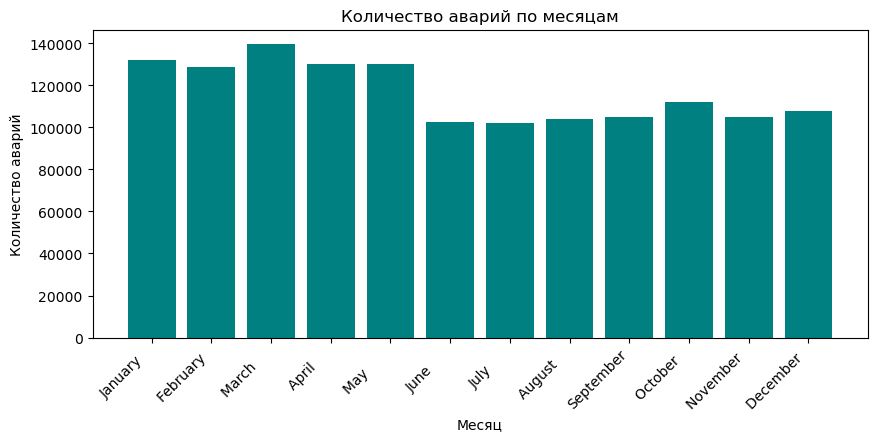

In [27]:
# визуолизация результатов
plt.figure(figsize=(10, 4))
plt.bar(df['month'], df['collision_count'], color='teal')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по месяцам')
plt.xticks(rotation=45, ha='right')
plt.show()

- Видно, что количество аварий имеет явные сезонные колебания в течение года.
- Наибольшее количество аварий обычно происходит в марте и октябре, что может быть связано с изменениями погоды и дорожных условий в эти месяцы.
- Наименьшее количество аварий зафиксировано в июне и июле, возможно, из-за летнего сезона и лучших дорожных условий.
- Аварийное количество кажется стабильным в период с августа по декабрь.

## Аналитические задачи

Эти задачи позволят лучше понять данные и провести дополнительный анализ для определения факторов, влияющих на возникновение ДТП, а также выявить потенциальные меры для предотвращения аварий.


__Задача 1:__

__Анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП.__
- Исследовать связь между состоянием дороги (ROAD_SURFACE) в момент ДТП и серьезностью повреждений транспортного средства (COLLISION_DAMAGE). 
- Определить, какие состояния дороги преобладают при различных уровнях серьезности повреждений, и сделайте выводы о влиянии состояния дороги на серьезность ДТП.

__Задача 2:__

__Анализ частых причин ДТП.__
- Используя таблицу "parties", определить самые частые причины ДТП (PCF_VIOLATION_CATEGORY). 
- Выстроить рейтинг причин в порядке убывания частоты аварий. 
- Определить рекомендации на основе этого анализа, чтобы предотвратить наиболее распространенные типы ДТП.

__Задача 3:__

__Анализ влияния уровня освещения на вероятность возникновения ДТП.__
- Сравнить количество ДТП в зависимости от уровня освещения (LIGHTING). 
- Определить, в какое время суток и в каких условиях освещения ДТП происходят наиболее часто. 
- Проанализировать, как уровень освещения влияет на вероятность возникновения ДТП.

__Задача 4:__

__Анализ распределения количества участников в ДТП.__
- Изучить количество участников (PARTY_COUNT) в каждом ДТП и определите распределение этой величины. 
- Определить, как часто происходят ДТП с большим количеством участников и сравните это с количеством ДТП с небольшим числом участников.

__Задача 5:__

__Анализ зависимости вероятности возникновения ДТП от погодных условий.__
- Изучить влияние погодных условий (WEATHER_1) на вероятность возникновения ДТП. 
- Сравнить количество ДТП в различных погодных условиях и определите, какие погодные условия сопровождаются наибольшим риском возникновения аварий.

__Задача 6:__

__Анализ влияния уровня опьянения участников на тяжесть ДТП.__
- Исследовать связь между уровнем опьянения участников ДТП (PARTY_SOBRIETY) и серьезностью аварий (COLLISION_DAMAGE). 
- Определить, какие уровни опьянения преобладают при различных уровнях серьезности повреждений транспортного средства. 
- Сравнить количество исходящихся аварий для каждого уровня опьянения и выявите, насколько опьянение участников влияет на тяжесть ДТП.

__Задача 7:__
__Анализ частоты ДТП в зависимости от времени суток и сотоянии дороги.__
- Объединить таблицы "collisions" и "vehicles" по общему ключу "case_id".
- Используя полученные данные для вычисления количества ДТП для каждого времени суток (утро, день, вечер, ночь) и типа дороги (городская, загородная, автострада).

__Задача 8:__
__Анализ влияния возраста автомобиля на тип аварий__
- Объединить таблицы "collisions" и " vehicles" по общему ключу "case_id" и получить данные о типах ДТП и возрасте автомобилей.
- Используя полученные данные, проанализируйте селичество и тип ДТП и связь их и возрастом автомобилей.

### Анализ частых причин ДТП.
Данный анализ поможет сосредоточить внимание на наиболее значимых проблемах и разработать эффективные стратегии для снижения аварийности и повышения безопасности на дорогах.

In [28]:
# sql запрос
query = '''
SELECT PCF_VIOLATION_CATEGORY, 
       COUNT(*) AS collision_count
FROM collisions
GROUP BY PCF_VIOLATION_CATEGORY
ORDER BY collision_count DESC
LIMIT 10;
'''

df = request(query)
display(df)

,pcf_violation_category,collision_count
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,unknown,39558
8,wrong side of road,33631
9,following too closely,30033


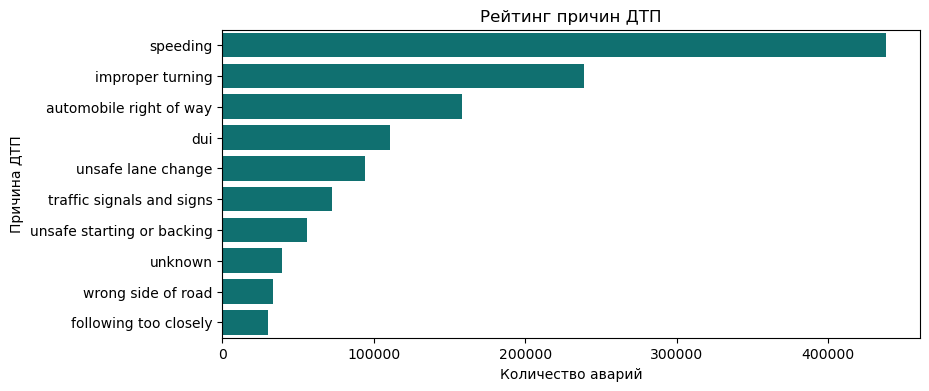

In [29]:
# визуолизация результатов
plt.figure(figsize=(9, 4))
sns.barplot(x='collision_count', y='pcf_violation_category', data=df, color='teal')
plt.xlabel('Количество аварий')
plt.ylabel('Причина ДТП')
plt.title('Рейтинг причин ДТП')
plt.show()

__Из результатов запроса видно, что самыми частыми причинами ДТП в данной базе данных являются:__
- Превышение скорости (Speeding) - 438,439 аварий.
- Неправильный поворот (Improper Turning) - 238,987 аварий.
- Автомобильное право проезда (Automobile Right of Way) - 158,291 аварий.
- Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения (DUI - Driving Under the Influence) - 110,476 аварий.

__Основываясь на этом анализе, можно предложить следующие рекомендации для предотвращения наиболее распространенных типов ДТП:__
- Повышать осведомленность и образованность водителей: Продвигать информационные кампании, обучающие водителей о безопасных практиках вождения, в том числе о соблюдении ограничений скорости и правильном повороте.
- Развивать системы контроля скорости: Внедрение автоматических систем контроля скорости на дорогах может снизить количество ДТП, связанных с превышением скорости.
- Расширить сеть камер наблюдения на дорогах: Установка камер на опасных участках дорог поможет отслеживать нарушения и устранять их.
- Поддерживать безопасные дорожные условия: Проводить регулярный мониторинг дорожного покрытия и инфраструктуры, чтобы обеспечить безопасное движение.
- Установить технологию, которая интегрирует алко-тест в систему зажигания автомобиля. Это поможет предотвращать аварии, связанные с вождением в состоянии алкогольного опьянения.

### Анализ зависимости вероятности возникновения ДТП от погодных условий.

In [30]:
# sql запрос
query = '''
SELECT WEATHER_1,
       COUNT(*) AS collision_count
FROM collisions
GROUP BY WEATHER_1
ORDER BY collision_count DESC;
'''

df = request(query)
display(df)

,weather_1,collision_count
0,clear,1121048
1,cloudy,203030
2,raining,57976
3,None,7259
4,fog,6156
5,snowing,2571
6,other,1516
7,wind,444


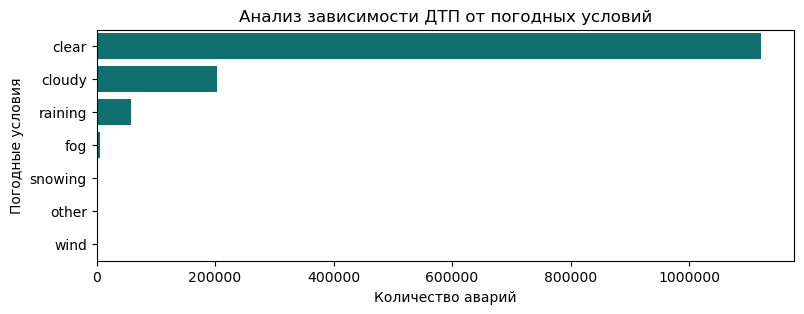

In [31]:
# визуолизация результатов
plt.figure(figsize=(9, 3))
sns.barplot(x='collision_count', y='weather_1', data=df, color='teal')
plt.xlabel('Количество аварий')
plt.ylabel('Погодные условия')
plt.title('Анализ зависимости ДТП от погодных условий')
plt.ticklabel_format(style='plain', axis='x')

plt.show()

__На основе результатов анализа зависимости вероятности возникновения ДТП от погодных условий, получены следующие данные:__
- В ясную погоду (clear) зарегистрировано наибольшее количество аварий - 1,121,048 случаев.
- За ясной погодой следует облачная погода (cloudy) с 203,030 авариями.
- Дождливая погода (raining) оказывается третьей по частоте причиной ДТП с 57,976 авариями.
- В условиях без указания погоды (None) произошло 7,259 аварий.
- Туман (fog) сопровождается 6,156 авариями.
- В снежную погоду (snowing) попало 2,571 аварий.
- Другие погодные условия (other) были отмечены в 1,516 случаев.
- Ветрено (wind) связано с 444 авариями.

__На основе этих результатов можно сделать следующие выводы рекомендации:__
- В ясную погоду произошли большинство оварий, что говорит, о там, что другие факторы могут оказать большее влияние на риск аварии.
- При вождении в облачную погоду и дождь также необходимо соблюдать повышенную осторожность и соблюдать дистанцию.
- В условиях тумана и снегопада водителям следует снизить скорость движения, использовать фары и габариты, чтобы быть видимыми другим участникам дорожного движения.


### Анализ влияния возраста автомобиля на тип аварий
Для более удобного анализа, автомобили были разделены на две категории: "Новые" - автомобили возрастом менее или равно 5 лет, и "Старые" - автомобили старше 5 лет.

In [32]:
# sql запрос
query = '''
SELECT 
    CASE
        WHEN VEHICLE_AGE > 5 THEN 'Старые автомобили'
        ELSE 'Новые автомобили'
    END AS vehicle_category,
    TYPE_OF_COLLISION,
    COUNT(*) AS collision_count
FROM collisions c
     JOIN vehicles v ON c.CASE_ID = v.CASE_ID
WHERE VEHICLE_AGE IS NOT NULL AND
      TYPE_OF_COLLISION IS NOT NULL
GROUP BY vehicle_category, TYPE_OF_COLLISION
ORDER BY vehicle_category, collision_count DESC;
'''

df = request(query)
display(df)

,vehicle_category,type_of_collision,collision_count
0,Новые автомобили,rear end,210736
1,Новые автомобили,broadside,143999
2,Новые автомобили,sideswipe,75521
3,Новые автомобили,hit object,72027
4,Новые автомобили,other,41445
5,Новые автомобили,head-on,30937
6,Новые автомобили,overturned,18089
7,Старые автомобили,rear end,151661
8,Старые автомобили,broadside,98836
9,Старые автомобили,sideswipe,48290


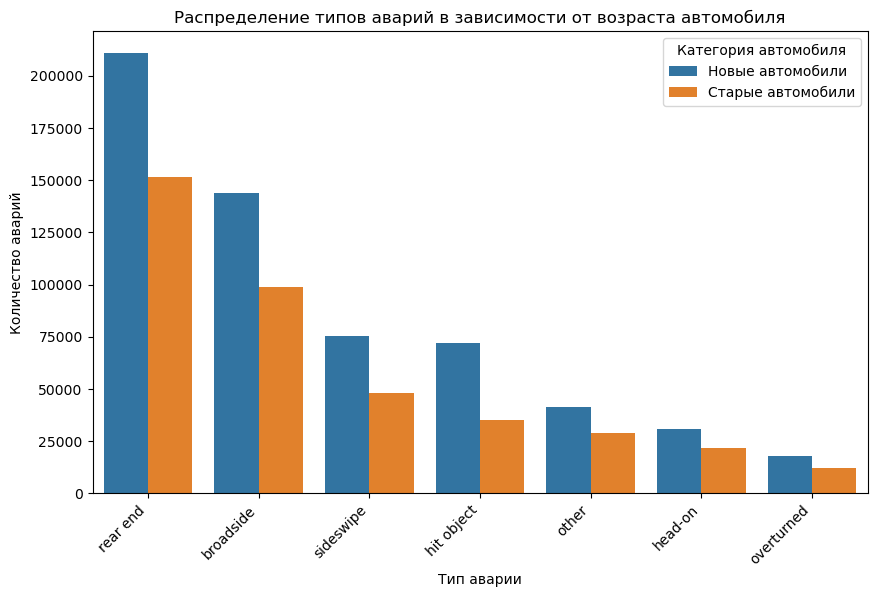

In [33]:
# визуолизация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x='type_of_collision', y='collision_count', hue='vehicle_category', data=df)
plt.xlabel('Тип аварии')
plt.ylabel('Количество аварий')
plt.title('Распределение типов аварий в зависимости от возраста автомобиля')
plt.legend(title='Категория автомобиля', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

- Проведенный анализ показывает, что независимо от возрастной категории автомобилей, самыми частыми типами аварий являются "rear end" (столкновение сзади) и "broadside" (боковое столкновение). При этом количество столкновений в категории "Старые автомобили" ниже, чем в категории "Новые автомобили". Однако, это можно объяснить общим количеством старых автомобилей, которые могут быть менее представлены на дорогах по сравнению с новыми автомобилями.

- Важно обратить внимание, что типы аварий остаются стабильными независимо от возраста автомобилей, что подчеркивает необходимость предоставления дополнительного внимания на профилактику  по предотвращению столкновений сзади и боковых столкновений, так как они являются наиболее распространенными.


### Анализ частоты ДТП в зависимости от времени суток и состояния дороги.

In [34]:
# sql запрос
query = '''
SELECT 
    CASE 
        WHEN EXTRACT(HOUR FROM collision_time) >= 0 AND EXTRACT(HOUR FROM collision_time) < 6 THEN 'Ночь'
        WHEN EXTRACT(HOUR FROM collision_time) >= 6 AND EXTRACT(HOUR FROM collision_time) < 12 THEN 'Утро'
        WHEN EXTRACT(HOUR FROM collision_time) >= 12 AND EXTRACT(HOUR FROM collision_time) < 18 THEN 'День'
        WHEN EXTRACT(HOUR FROM collision_time) >= 18 AND EXTRACT(HOUR FROM collision_time) < 24 THEN 'Вечер'
    END AS time_of_day,
    road_surface,
    COUNT(*) AS collision_count
FROM collisions c
     JOIN vehicles v ON c.case_id = v.case_id
WHERE road_surface IS NOT NULL AND collision_time IS NOT NULL
GROUP BY time_of_day, road_surface
ORDER BY time_of_day, collision_count DESC;
'''

df = request(query)
display(df)

,time_of_day,road_surface,collision_count
0,Вечер,dry,212148
1,Вечер,wet,20743
2,Вечер,snowy,941
3,Вечер,slippery,179
4,День,dry,415081
5,День,wet,33386
6,День,snowy,1708
7,День,slippery,330
8,Ночь,dry,63079
9,Ночь,wet,8966


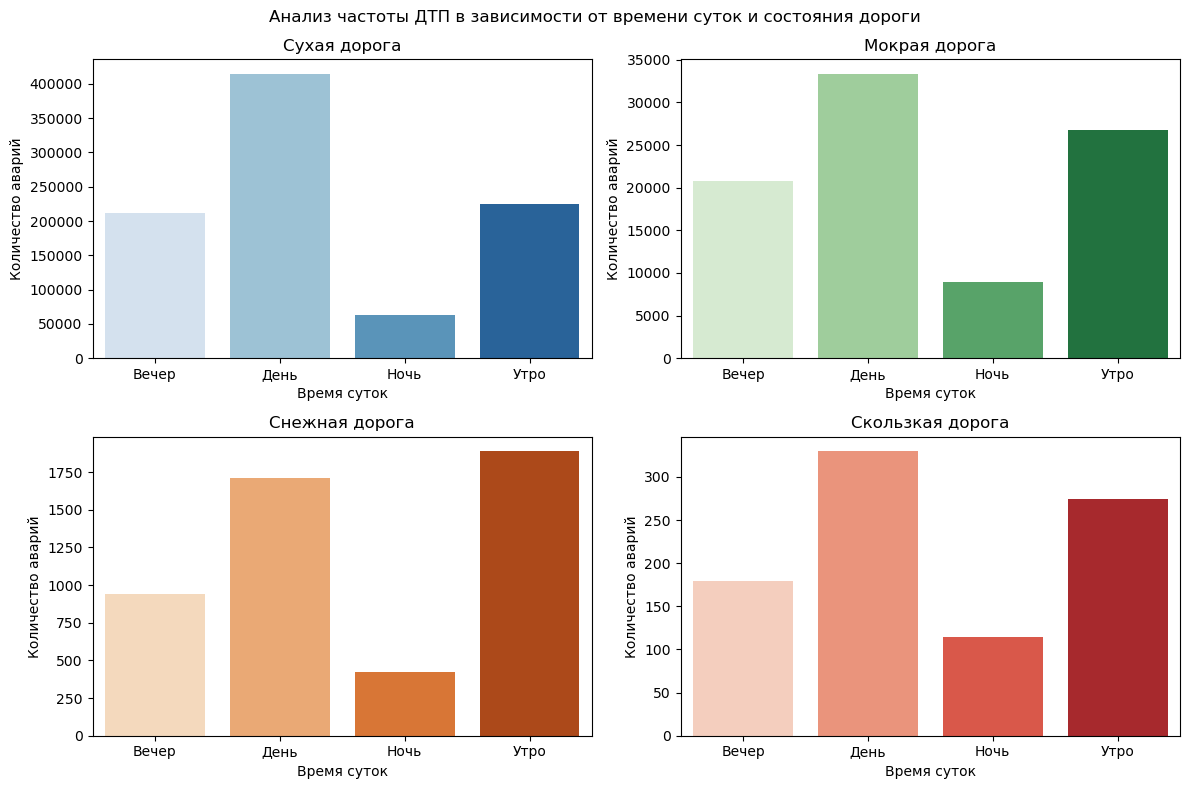

In [35]:
# визуолизация результатов
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Анализ частоты ДТП в зависимости от времени суток и состояния дороги')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'dry'],
            ax=axes[0, 0],
            palette='Blues')
axes[0, 0].set_title('Сухая дорога')
axes[0, 0].set_xlabel('Время суток')
axes[0, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day',
            y='collision_count',
            data=df[df['road_surface'] == 'wet'],
            ax=axes[0, 1],
            palette='Greens')
axes[0, 1].set_title('Мокрая дорога')
axes[0, 1].set_xlabel('Время суток')
axes[0, 1].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'snowy'], 
            ax=axes[1, 0], 
            palette='Oranges')
axes[1, 0].set_title('Снежная дорога')
axes[1, 0].set_xlabel('Время суток')
axes[1, 0].set_ylabel('Количество аварий')

sns.barplot(x='time_of_day', 
            y='collision_count', 
            data=df[df['road_surface'] == 'slippery'], 
            ax=axes[1, 1], 
            palette='Reds')
axes[1, 1].set_title('Скользкая дорога')
axes[1, 1].set_xlabel('Время суток')
axes[1, 1].set_ylabel('Количество аварий')

plt.tight_layout()
plt.show()

__Анализ частоты ДТП в зависимости от времени суток и состояния дороги позволил выявить интересные тенденции и сделать следующие выводы:__

- Наибольшее количество ДТП происходит на сухой дороге, что можно объяснить тем, что сухая дорога обеспечивает лучшее сцепление между шинами автомобиля и дорожным покрытием. Это может приводить к повышенной скорости движения, большей агрессивному вождению и возможному несоблюдению правил дорожного движения, так как водители чувствуют себя более уверенно на сухой дороге. Также, наличие сухого дорожного покрытия способствует более свободному движению автомобилей, что может привести к увеличению числа ДТП.

- С другой стороны, наличие дождя, снега или скользкого дорожного покрытия создает более опасные условия для движения, что заставляет водителей быть более осторожными, снизить скорость и быть более внимательными к дорожной обстановке или совсем отказаться от использования автомобиля. Это может приводить к снижению количества ДТП в условиях плохой погоды.

- Вне зависимости от состояния дороги (сухой, мокрый, снежный или скользкий), большинство ДТП происходят утром и днем. Это может быть связано с увеличенным движением транспорта в этот период.

- В случае, когда дорога заснежена (снежное состояние), наибольшее количество ДТП происходит именно утром. Это может быть связано с тем, что утром снег еще не успели полностью очистить, и дороги оказываются скользкими и опасными для движения.

- Таким образом, данные результаты могут помочь сфокусироваться на участках дорог, которые являются наиболее опасными в зависимости от времени суток и состояния дороги. Это может быть полезной информацией для дальнейшего анализа и разработки модели.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению моделей

</div>

Подготовим набор данных на основе первичного предположения заказчика:

- Выберем только те случаи, где виновником является автомобиль (car).
- Учтем случаи, когда происшествие привело к значительным повреждениям автомобиля у любого из участников, за исключением типа SCRATCH (царапина).
- Для построения модели мы ограничимся данными только за 2012 год, поскольку они являются наиболее актуальными.

In [126]:
# sql запрос
query = '''
SELECT *
FROM parties p INNER JOIN
     vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number LEFT JOIN
     collisions c ON p.case_id = c.case_id
WHERE p.case_id IN (SELECT case_id
                    FROM parties
                    WHERE PARTY_TYPE = 'car' AND
                          AT_FAULT = 1) AND
      c.COLLISION_DAMAGE NOT IN ('SCRATCH') AND
      EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;

'''

df = request(query)
display(df.head())

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,...,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,2406376,5454846,3,car,0,28.0,had not been drinking,None,0.0,1326456,...,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2012-01-10,19:26:00
1,2419055,5461655,1,car,1,67.0,had not been drinking,None,0.0,1333128,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights not functioning,none,2012-01-20,17:39:00
2,2429262,5467091,1,car,1,18.0,had not been drinking,None,0.0,1338661,...,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with no street lights,none,2012-01-14,22:56:00
3,2459476,5483391,3,car,1,28.0,had not been drinking,None,0.0,1355295,...,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,none,2012-01-04,19:05:00
4,2485784,5497526,1,car,1,26.0,had not been drinking,None,0.0,1369471,...,vehicle code violation,improper turning,overturned,non-collision,dry,normal,daylight,none,2012-01-15,09:55:00


## Первичный отбор факторов, необходимых для построения модели

__Признаки не подходящие для дальнейшего анализа:__
- Признаки `id`, `case_id` можно заменить уникальным идентификатором датафрейма.
- `party_number` - Номер участника происшествия: не несет информации для анализа, а используется для структурирования базы данных, его так же можно удалить.
- `party_type` - Тип участника происшествия: содержит значения: 'car', 'building', 'road signs', 'other', 'road bumper', None. Необходимо оставить записи только с участником 'car', остальные записи не несут дополнительной информации о месте происшествия, тк она будет дублироваться соответствующей записью с машиной. Затем данный признак так же следует удалить.
- `county_city_location` - Номер географических районов, где произошло ДТП: содержит много уникальных значений и не будет использовано в построении модели, тк это приведет к уменьшению обобщающей способности.

Следующие признаки, так же малозначемы для построения Модели, так как они определяются уже после ДТП и при прогнозировании не доступны:
- `party_count` - Количество участников
- `primary_collision_factor` - Основной фактор аварии
- `pcf_violation_category` - Категория нарушения
- `type_of_collision` - Тип аварии
- `motor_vehicle_involved_with` - Дополнительные участники ДТП
- `intersection` - Является ли место происшествие перекрёстком
- `collision_damage` - Серьёзность происшествия

__Признаки которые могут оказать косвенное влияние:__
- `location_type` - Тип дороги
- `direction` - Направление движения
- `county_location` - Названия географических районов, где произошло ДТП
- `vehicle_transmission` - Тип КПП
- `vehicle_type` - Тип кузова
- `insurance_premium` - Сумма страховки: возможно, при наличии страховки, водитель чувствует излишнюю уверенности и это может повлиять на его манеру вождения, на данный момент этот признак следует оставить.
- `distance` - Расстояние от главной дороги (метры)
- `cellphone_in_use` Наличие - Телефона в автомобиле (возможности разговаривать по громкой связи)

__Важные признаки:__
- `party_sobriety` - Трезвость участника
- `party_drug_physical` - Состояние участника
- `vehicle_age` - Возраст автомобиля (в годах)
- `road_surface` - Состояние дороги
- `road_condition_1` - Дорожное состояние
- `lighting` - Освещение
- `control_device` - Работоспособность устройств управления
- `collision_date` - Дата происшествия
- `collision_time` - Время происшествия
- `weather_1` - Погода

- `at_fault` - Виновность участника: является целевым признаком

__Пнрвичная подготовка данных__

In [127]:
# фильтрайия по типу участника происшествия 
df = df[df['party_type']=='car']
# удаление малозначемых признаков
df = df.drop(['id', 'case_id', 'party_number', 'party_type', 'county_city_location', 
             'party_count', 'primary_collision_factor', 'pcf_violation_category', 'type_of_collision', 
             'motor_vehicle_involved_with', 'intersection', 'collision_damage'], axis=1)
# добавление `index`
df = df.reset_index()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [128]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96966 entries, 0 to 96965
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 96966 non-null  int64  
 1   at_fault              96966 non-null  int64  
 2   insurance_premium     96214 non-null  float64
 3   party_sobriety        95570 non-null  object 
 4   party_drug_physical   3942 non-null   object 
 5   cellphone_in_use      87913 non-null  float64
 6   vehicle_type          96966 non-null  object 
 7   vehicle_transmission  95199 non-null  object 
 8   vehicle_age           94545 non-null  float64
 9   county_location       96966 non-null  object 
 10  distance              96966 non-null  float64
 11  direction             71771 non-null  object 
 12  weather_1             96725 non-null  object 
 13  location_type         41203 non-null  object 
 14  road_surface          96268 non-null  object 
 15  road_condition_1   

None

In [129]:
# функция для проверки пропусков
def f_isna(x):
    print(f"Количество пропусков в столбце {x}: {df[x].isna().sum()/len(df)}%")
    
# функция для проверки линейной зависимости с целевым признаком
def f_corr(x):
    print(f"Линейная связь с целевым признаком: {df[['at_fault', x]].corr().iloc()[0][1]}")

# функция для проверки нелинейной зависимости phik с целевым признаком
def f_phik(x):
    phik = df[['at_fault', x]].phik_matrix().iloc()[0][1]
    print(f"Phik: {phik}")

- Присутствуют пропуски, обработку которых проведем в следующих шагах, так как нет единой стратегии их заполнения.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ и обработка числовых признаков
    
</div>

In [130]:
df[['at_fault', 'insurance_premium', 'cellphone_in_use', 'vehicle_age', 'distance']].describe().T

,count,mean,std,min,25%,50%,75%,max
at_fault,96966.0,0.475734,0.499413,0.0,0.0,0.0,1.0,1.0
insurance_premium,96214.0,38.530370,16.248737,0.0,25.0,36.0,50.0,104.0
cellphone_in_use,87913.0,0.020714,0.142425,0.0,0.0,0.0,0.0,1.0
vehicle_age,94545.0,5.206071,3.120605,0.0,3.0,5.0,7.0,161.0
distance,96966.0,701.654741,5668.534327,0.0,0.0,100.0,500.0,1584000.0


### at_fault - виновность участника ДТП
Данный признак является целевым.

In [131]:
f_isna('at_fault')

Количество пропусков в столбце at_fault: 0.0%


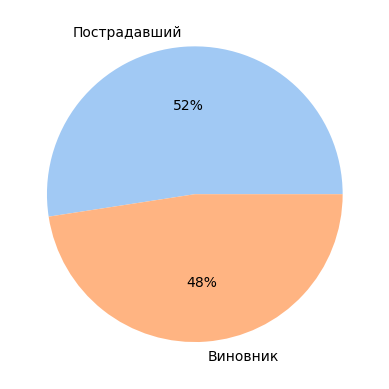

In [132]:
# баланс целевого признака
data = [df['at_fault'].value_counts()[0], df['at_fault'].value_counts()[1]]
labels = ['Пострадавший', 'Виновник']

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

- Пропуски отсутствуют.
- Баланс целевого признака хороший, 52% и 48%

### insurance_premium - сумма страховки

In [133]:
# статистика
f_isna('insurance_premium')
f_corr('insurance_premium')
f_phik('insurance_premium')

Количество пропусков в столбце insurance_premium: 0.0077552956706474436%
Линейная связь с целевым признаком: -0.1265770035282736
interval columns not set, guessing: ['at_fault', 'insurance_premium']
Phik: 0.26655673497640947


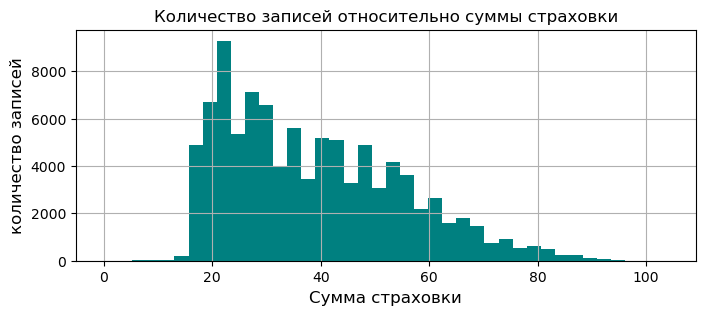

In [135]:
# визуализация количества подтверждённых заказов
plt.figure(figsize=(8,3))
plt.hist(df['insurance_premium'], bins=40, color='teal')
plt.grid(True)
plt.title('Количество записей относительно суммы страховки')
plt.xlabel('Сумма страховки', fontsize=12)
plt.ylabel('количество записей', fontsize=12)

plt.show()

В случае отсутствия данных в данном признаке, мы заменим пропуски на значение 0, поскольку это может указывать на отсутствие страховки у соответствующего участника.

In [136]:
df['insurance_premium'] = df['insurance_premium'].fillna(0)

In [137]:
# обновленная статистика
f_isna('insurance_premium')
f_corr('insurance_premium')
f_phik('insurance_premium')

Количество пропусков в столбце insurance_premium: 0.0%
Линейная связь с целевым признаком: -0.1342323952683906
interval columns not set, guessing: ['at_fault', 'insurance_premium']
Phik: 0.2738341854198687


- Пропуски заполнены.
- После заполнения пропусков, связь данного признака с целевым усилился.

### cellphone_in_use -  наличие телефона в автомобиле

In [138]:
# статистика
f_isna('cellphone_in_use')
f_corr('cellphone_in_use')
f_phik('cellphone_in_use')

Количество пропусков в столбце cellphone_in_use: 0.09336262194996184%
Линейная связь с целевым признаком: 0.014180192123375134
interval columns not set, guessing: ['at_fault', 'cellphone_in_use']
Phik: 0.021504475537408408


- Связь данного признака с целевым переменным является слабой.
- Следует учесть, что в настоящее время большинство людей используют смартфоны, что делает данный признак менее актуальным для исследования. Рекомендуется исключить данный признак из анализа и построения моделей.

In [139]:
df = df.drop('cellphone_in_use', axis=1)

- Данный признак не имеет репрезентативной силы.
- Было принято решение исключить данный признак из дальнейшего анализа.

#### vehicle_age - возраст автомобиля (в годах)

In [141]:
# пропуски
f_isna('vehicle_age')

Количество пропусков в столбце vehicle_age: 0.024967514386485985%


Данные о возрасте автомобилей невозможно восстановить на основе остальных данных, то разумным решением будет исключить записи с пропущенными значениями возраста из анализа.

In [146]:
# обработка пропусков
df = df.dropna(subset=['vehicle_age']).copy()

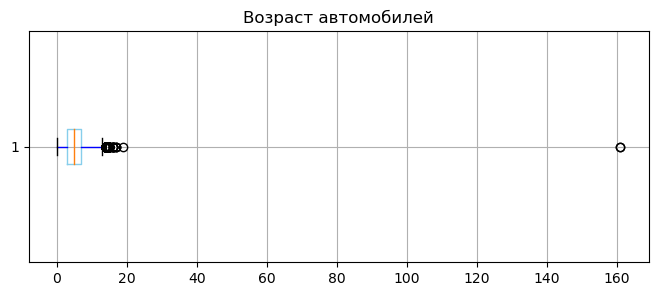

In [147]:
# boxplot для признака vehicle_age
plt.figure(figsize=(8,3))
plt.boxplot(df['vehicle_age'], vert=False, boxprops=dict(color='skyblue'), whiskerprops=dict(color='blue'))
plt.grid(True)
plt.title('Возраст автомобилей')
plt.show()

Рекомендуется ограничить максимальный возраст автомобилей, исходя из значений 25-го и 75-го квантилей, чтобы исключить аномальные значения.

In [155]:
# рассчет орога аномальных значений
q1 = df['vehicle_age'].quantile(0.25)
q3 = df['vehicle_age'].quantile(0.75)
print(f'Порог аномальных значений: {int(q3+2.5*(q3-q1))} лет')

Порог аномальных значений: 19 лет


In [153]:
df = df[df['vehicle_age']<=(q3+2.5*(q3-q1))]

In [156]:
# статистика
f_corr('vehicle_age')
f_phik('vehicle_age')

Линейная связь с целевым признаком: -0.09687363531102493
interval columns not set, guessing: ['at_fault', 'vehicle_age']
Phik: 0.22307408419985225


- Обработаны пропуски и аномальные значения.
- Присутствует связь данного признака с целевым.

### distance - расстояние от главной дороги

In [160]:
# статистика
f_isna('distance')
f_corr('distance')
f_phik('distance')

Количество пропусков в столбце distance: 0.0%
Линейная связь с целевым признаком: 0.04048321671376471
interval columns not set, guessing: ['at_fault', 'distance']
Phik: 0.0008939222252192158


Связь данного признака с целевым переменным является слабой. Рекомендуется исключить данный признак из анализа и построения моделей.

In [182]:
df = df.dropna(subset=['distance']).copy()

- Данный признак не имеет репрезентативной силы.
- Было принято решение исключить данный признак из дальнейшего анализа.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ категориальные признаков
    
</div>

## Создайте модель для оценки водительского риска

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96966 entries, 0 to 96965
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 96966 non-null  int64  
 1   at_fault              96966 non-null  int64  
 2   insurance_premium     96214 non-null  float64
 3   party_sobriety        95570 non-null  object 
 4   party_drug_physical   3942 non-null   object 
 5   cellphone_in_use      87913 non-null  float64
 6   vehicle_type          96966 non-null  object 
 7   vehicle_transmission  95199 non-null  object 
 8   vehicle_age           94545 non-null  float64
 9   county_location       96966 non-null  object 
 10  distance              96966 non-null  float64
 11  direction             71771 non-null  object 
 12  weather_1             96725 non-null  object 
 13  location_type         41203 non-null  object 
 14  road_surface          96268 non-null  object 
 15  road_condition_1   

## Проведите анализ важности факторов ДТП

## Выводы

In [ ]:
# Закрываем курсор и соединение
#cursor.close()
#connection.close()